In [38]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

In [39]:
!pip install onnx

In [40]:
import onnx

In [41]:
data_train = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
data_test = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [42]:
print(data_train.data.size())
print(data_train.targets.size())

torch.Size([60000, 28, 28])
torch.Size([60000])


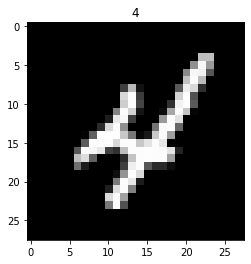

In [43]:
plt.imshow(data_train.data[9], cmap='gray')
plt.title('%i' % data_train.targets[9])
plt.show()

In [44]:
loaders = {
    'train' : torch.utils.data.DataLoader(data_train, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(data_test, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7fa27dcca850>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7fa27dda3f10>}

In [45]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
       
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x

In [46]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [47]:
loss_func = nn.CrossEntropyLoss()   

In [48]:
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   


In [49]:
num_epochs = 10
def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            b_x = Variable(images)  
            b_y = Variable(labels)   
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
              
            optimizer.zero_grad()           
    
            loss.backward()               
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
           
train(num_epochs, cnn, loaders)

Epoch [1/10], Step [100/600], Loss: 0.2080
Epoch [1/10], Step [200/600], Loss: 0.3088
Epoch [1/10], Step [300/600], Loss: 0.0721
Epoch [1/10], Step [400/600], Loss: 0.0395
Epoch [1/10], Step [500/600], Loss: 0.0889
Epoch [1/10], Step [600/600], Loss: 0.1731
Epoch [2/10], Step [100/600], Loss: 0.0820
Epoch [2/10], Step [200/600], Loss: 0.0222
Epoch [2/10], Step [300/600], Loss: 0.0889
Epoch [2/10], Step [400/600], Loss: 0.0525
Epoch [2/10], Step [500/600], Loss: 0.0416
Epoch [2/10], Step [600/600], Loss: 0.0712
Epoch [3/10], Step [100/600], Loss: 0.0735
Epoch [3/10], Step [200/600], Loss: 0.0823
Epoch [3/10], Step [300/600], Loss: 0.1488
Epoch [3/10], Step [400/600], Loss: 0.0516
Epoch [3/10], Step [500/600], Loss: 0.1780
Epoch [3/10], Step [600/600], Loss: 0.1208
Epoch [4/10], Step [100/600], Loss: 0.0644
Epoch [4/10], Step [200/600], Loss: 0.0553
Epoch [4/10], Step [300/600], Loss: 0.0185
Epoch [4/10], Step [400/600], Loss: 0.0200
Epoch [4/10], Step [500/600], Loss: 0.0567
Epoch [4/10

In [50]:
def test():
  cnn.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in loaders['test']:
      test_output, last_layer = cnn(images)
      pred_y = torch.max(test_output, 1)[1].data.squeeze()
      accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
      pass
  print('Test Accuracy : %.2f' % accuracy)

test()


    

Test Accuracy : 0.99


In [51]:
torch.save(cnn.state_dict(), 'mnist.pt')

In [52]:
trained_model = CNN()
trained_model.load_state_dict(torch.load('mnist.pt'))

dummy_input = Variable(torch.randn(1, 1, 28, 28)) 
torch.onnx.export(trained_model, dummy_input, "mnist.onnx")